In [1]:
# Imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization, LeakyReLU
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.var_model import VAR
import tensorflow as tf
import time

In [2]:
start = time.time()

In [3]:
# Don't run this block of code if you aren't using Tensorflow-GPU.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 1


In [4]:
# Reading the data set.
walmart = pd.read_csv('WMT.csv')

In [5]:
# First 5 entries in the data set.
print('First 5 entries in the data set:\n', walmart.head())

First 5 entries in the data set:
          Date    Open     High      Low    Close  Adj Close   Volume
0  2000-01-03  68.375  69.0000  65.5000  66.8125  45.753605  8369900
1  2000-01-04  65.500  65.8125  64.1875  64.3125  44.041595  6745100
2  2000-01-05  63.875  64.3750  62.1875  63.0000  43.142776  7018700
3  2000-01-06  63.000  64.5625  62.6875  63.6875  43.613594  6544500
4  2000-01-07  64.500  68.9375  64.5000  68.5000  46.909222  7976900


In [6]:
# Shape of the data set.
print('\nData set Shape:\n', walmart.shape)


Data set Shape:
 (5031, 7)


In [7]:
# Description of the data set.
print('\nData set description:\n', walmart.describe())


Data set description:
               Open         High          Low        Close    Adj Close  \
count  5031.000000  5031.000000  5031.000000  5031.000000  5031.000000   
mean     63.352913    63.910212    62.807056    63.362401    51.747292   
std      16.866083    16.911829    16.828010    16.870848    20.336000   
min      42.000000    42.680000    41.437500    42.270000    29.720531   
25%      51.115000    51.750000    50.565000    51.174999    36.933237   
50%      56.500000    57.110001    55.759998    56.419998    41.810890   
75%      73.800003    74.165001    73.350003    73.770001    64.352356   
max     124.599998   125.379997   120.699997   121.279999   120.216911   

             Volume  
count  5.031000e+03  
mean   1.106437e+07  
std    6.846935e+06  
min    2.031400e+06  
25%    6.698600e+06  
50%    9.040200e+06  
75%    1.330850e+07  
max    9.678680e+07  


In [8]:
# Data set info.
print('\nData set info:\n', walmart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 7 columns):
Date         5031 non-null object
Open         5031 non-null float64
High         5031 non-null float64
Low          5031 non-null float64
Close        5031 non-null float64
Adj Close    5031 non-null float64
Volume       5031 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 275.2+ KB

Data set info:
 None


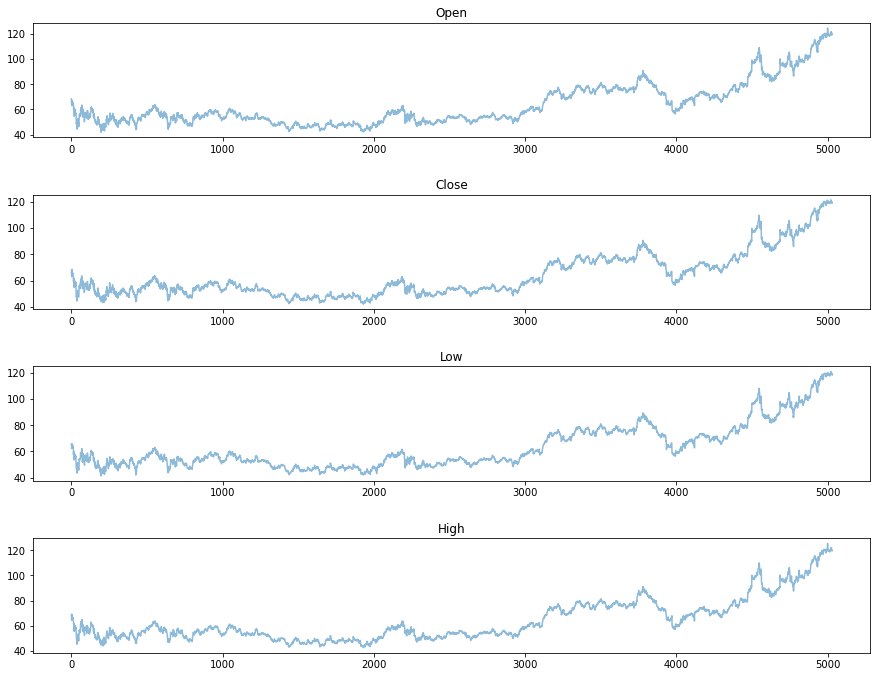

In [9]:
# Visualization of the data set.
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
axes[0].plot(walmart['Open'], alpha=0.5)
axes[0].title.set_text('Open')
axes[1].plot(walmart['Close'], alpha=0.5)
axes[1].title.set_text('Close')
axes[2].plot(walmart['Low'], alpha=0.5)
axes[2].title.set_text('Low')
axes[3].plot(walmart['High'], alpha=0.5)
axes[3].title.set_text('High')
plt.subplots_adjust(top=1, wspace=0, hspace=0.5)
plt.show()

In [10]:
# Splitting the dataset into training dataset and testing dataset.
training_data, testing_data = walmart[0:int(len(walmart)*0.8)], walmart[int(len(walmart)*0.8):]
print('\nTraining Dataset Shape:', training_data.shape)
print('\nTesting Dataset Shape:', testing_data.shape)


Training Dataset Shape: (4024, 7)

Testing Dataset Shape: (1007, 7)


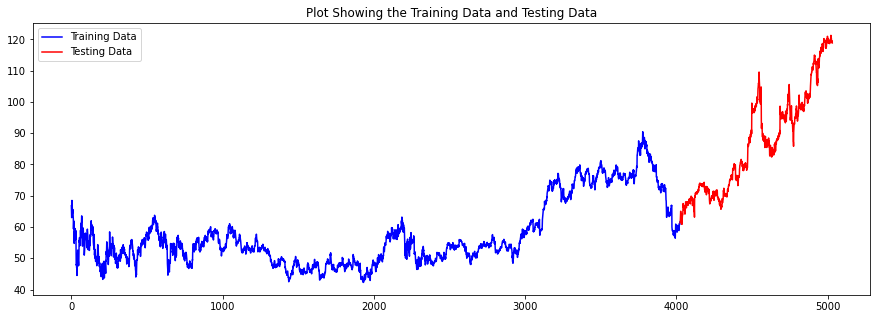

In [11]:
# Plot showing the training and testing data.
plt.figure(figsize=(15, 5))
plt.plot(training_data['Close'], 'blue', label='Training Data')
plt.plot(testing_data['Close'], 'red', label='Testing Data')
plt.legend()
plt.title('Plot Showing the Training Data and Testing Data')
plt.show()

# ARIMA Model

In [12]:
train_arima = training_data['Close'].values
test_arima = testing_data['Close'].values
history = [x for x in train_arima]
predictions = list()

In [13]:
for i in range(len(test_arima)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predictions.append(output[0])
    obs = test_arima[i]
    history.append(obs)

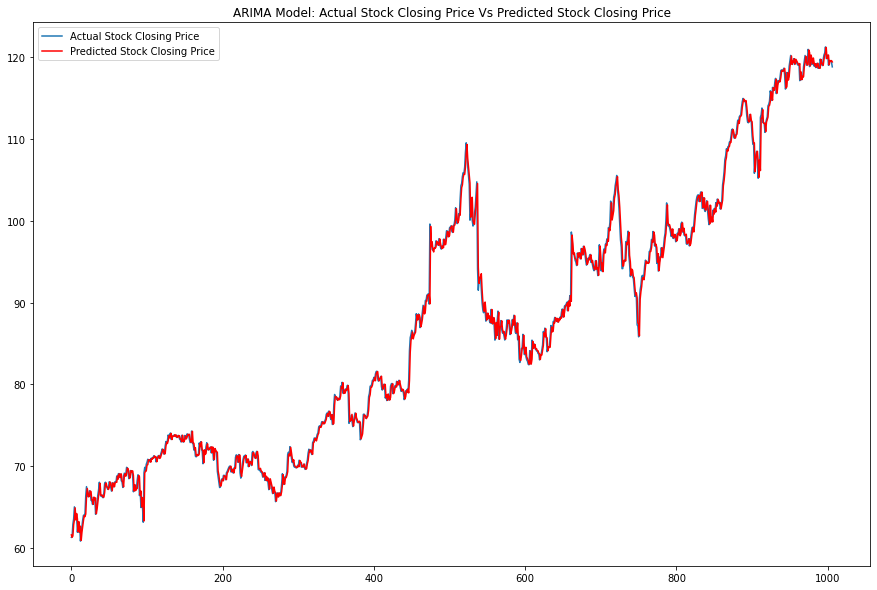

In [14]:
# Plotting the Actual Stock Closing Price vs Predicted Stock Closing Price.
plt.figure(figsize=(15, 10))
plt.plot(test_arima, label='Actual Stock Closing Price')
plt.plot(predictions, color='red', label='Predicted Stock Closing Price')
plt.legend()
plt.title('ARIMA Model: Actual Stock Closing Price Vs Predicted Stock Closing Price')
plt.show()

In [15]:
# Mean Squared Error
mse_arima = mean_squared_error(test_arima, predictions)
print('\nMSE of ARIMA Model is:', mse_arima)


MSE of ARIMA Model is: 1.137516253457746


# Auto Regression Model

In [16]:
# Making the data stationary by first differencing.
train_ar = training_data['Close']
train_ar = train_ar.diff().dropna()
test_ar = testing_data['Close'].values
history = [x for x in train_ar.values]
predictions = list()

In [17]:
for i in range(len(test_ar)):
    model = AutoReg(history, lags=2)
    model_fit = model.fit()
    output = model_fit.predict(start=len(train_ar), end=len(train_ar) + len(test_ar))
    predictions.append(output[0] + test_ar[i])
    obs = test_ar[i]
    history.append(obs)

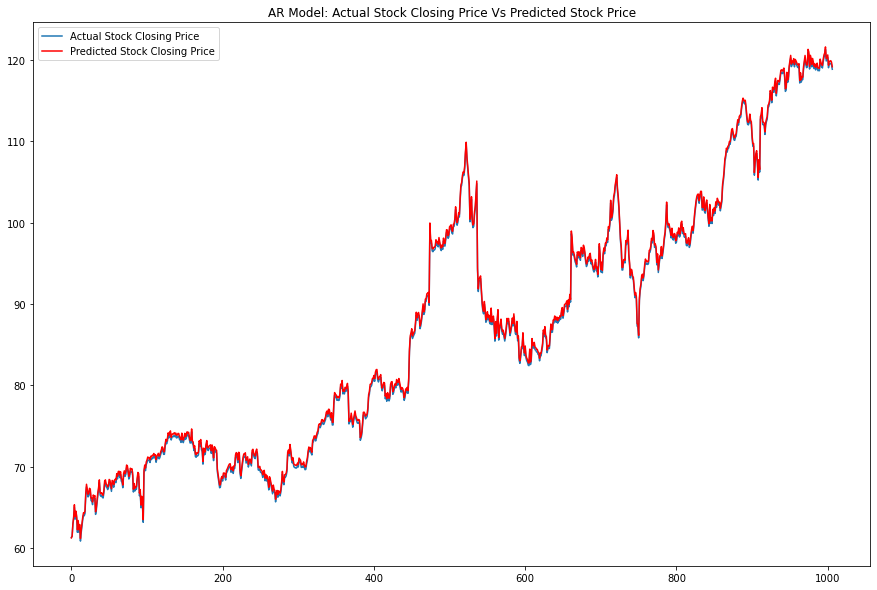

In [18]:
# Plotting the Actual Stock Closing Price vs Predicted Stock Closing Price.
plt.figure(figsize=(15, 10))
plt.plot(test_ar, label='Actual Stock Closing Price')
plt.plot(predictions, color='red', label='Predicted Stock Closing Price')
plt.legend()
plt.title('AR Model: Actual Stock Closing Price Vs Predicted Stock Price')
plt.show()

In [19]:
# Mean Squared Error
mse_ar = mean_squared_error(test_ar, predictions)
print('\nMSE of AR Model is:', mse_ar)


MSE of AR Model is: 0.10257225205346769


# VAR Model.

In [20]:
# Making the data stationary by first differencing.
train_var = training_data[['Open', 'Close']]
train_var = train_var.diff().dropna()
test_var = testing_data[['Open', 'Close']]
history = [x for x in train_var[['Open', 'Close']].values]
predictions = list()

In [21]:
for i in range(len(test_var)):
    model = VAR(endog=history)
    model_fit = model.fit()
    output = model_fit.forecast(model_fit.y, steps=len(test_var))
    predictions.append(output[i, 1])
    obs = test_var.iloc[i]
    history.append(obs)

c:\program files\python36\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


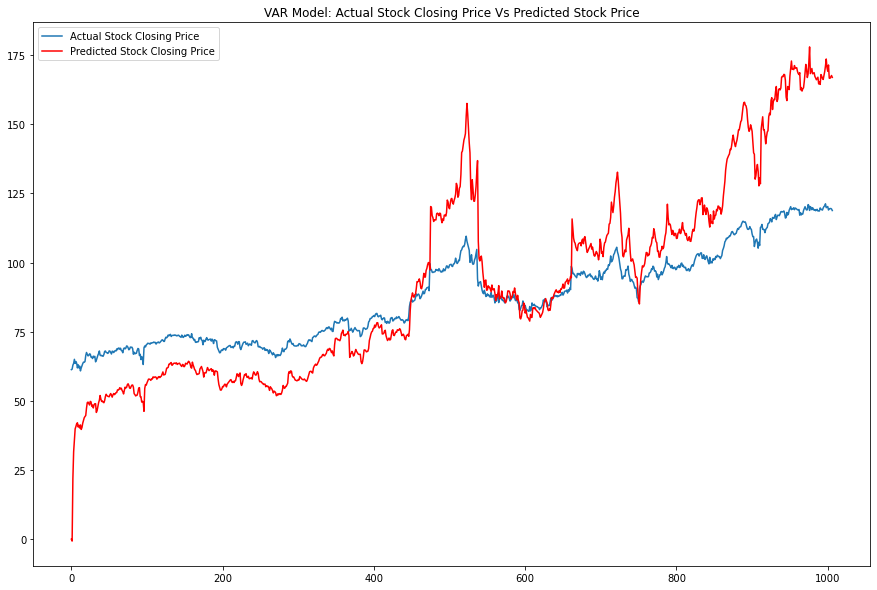

In [22]:
# Plotting the Actual Stock Closing Price vs Predicted Stock Closing Price.
plt.figure(figsize=(15, 10))
plt.plot(test_var['Close'].values, label='Actual Stock Closing Price')
plt.plot(predictions, color='red', label='Predicted Stock Closing Price')
plt.legend()
plt.title('VAR Model: Actual Stock Closing Price Vs Predicted Stock Price')
plt.show()

In [23]:
# Calculate Mean Squared Error:
mse = mean_squared_error(test_var['Close'], predictions)
print('\nMSE of VAR Model is:', mse)


MSE of VAR Model is: 416.5022697772365


# MLP

In [24]:
data = pd.read_csv('WMT.csv')[::-1]
data = data.loc[:, 'Close'].tolist()

In [25]:
# Shuffling in unison.
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [26]:
def create_xt_yt(x_, y_, percentage=0.8):
    p = int(len(x_) * percentage)
    x__train = x_[0:p]
    y__train = y_[0:p]

    x__train, y__train = shuffle_in_unison(x__train, y__train)

    x__test = x_[p:]
    y__test = y_[p:]

    return x__train, x__test, y__train, y__test

In [27]:
# Parameters.
WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 1

In [28]:
X, Y = [], []
for i in range(0, len(data), STEP):
    try:
        x_i = data[i:i + WINDOW]
        y_i = data[i + WINDOW + FORECAST]

        last_close = x_i[WINDOW - 1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1]

    except Exception as e:
        print(e)
        break
        
    X.append(x_i)
    Y.append(y_i)
    
X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_xt_yt(X, Y)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

list index out of range
(4000, 30)
(1000, 30)
(4000, 2)
(1000, 2)


# Setup 1

In [29]:
# Instantiating the model.
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=30))
model.add(Dense(2))
model.add(Activation('softmax'))
optimizer = Adam()

In [30]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, batch_size=128, verbose=0, validation_data=(X_test, Y_test),
                    shuffle=True)

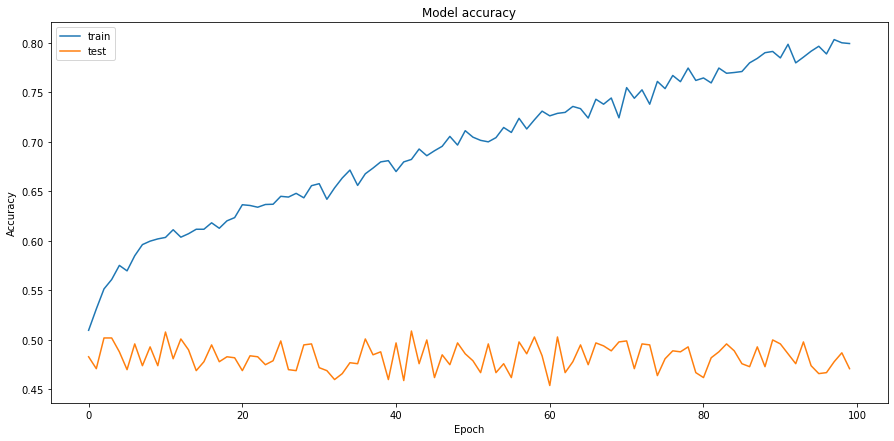

In [31]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

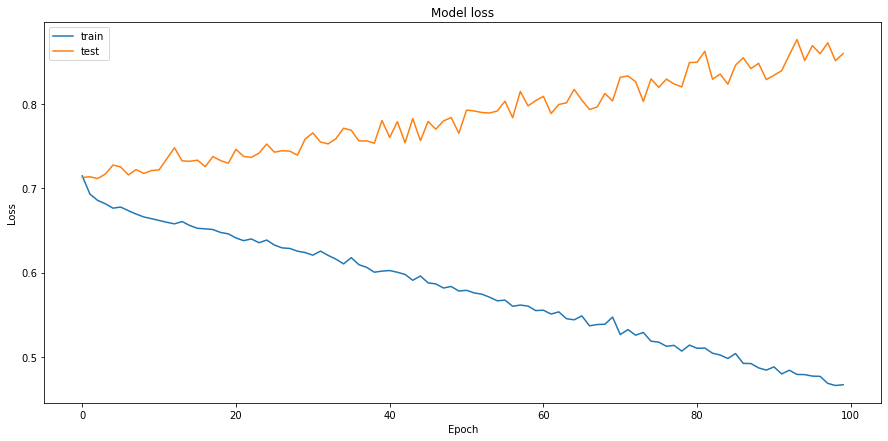

In [32]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Setup 2

In [33]:
# Instantiating the model.
model = Sequential()
model.add(Dense(512, input_dim=30, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(128, activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(2))
model.add(Activation('softmax'))
optimizer = Adam()

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0001, verbose=0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=150, batch_size=128, verbose=0, validation_data=(X_test, Y_test),
                    shuffle=True, callbacks=[reduce_lr])

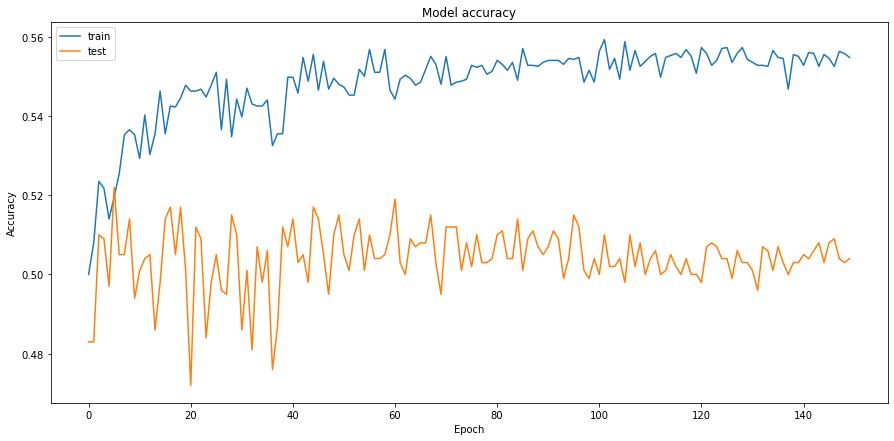

In [35]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

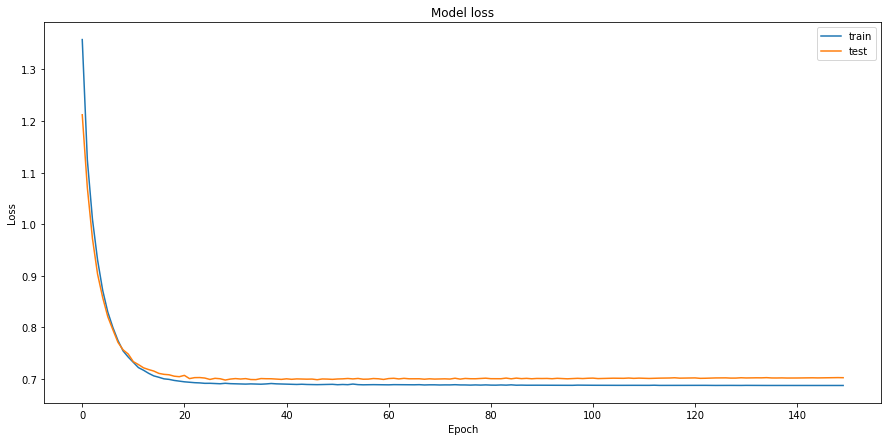

In [36]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# Setup 3

In [37]:
# Instantiating the model.
model = Sequential()
model.add(Dense(1024, input_dim=30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))
optimizer = Adam()

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0001, verbose=1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=0, validation_data=(X_test, Y_test),
                    shuffle=True, callbacks=[reduce_lr])


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.


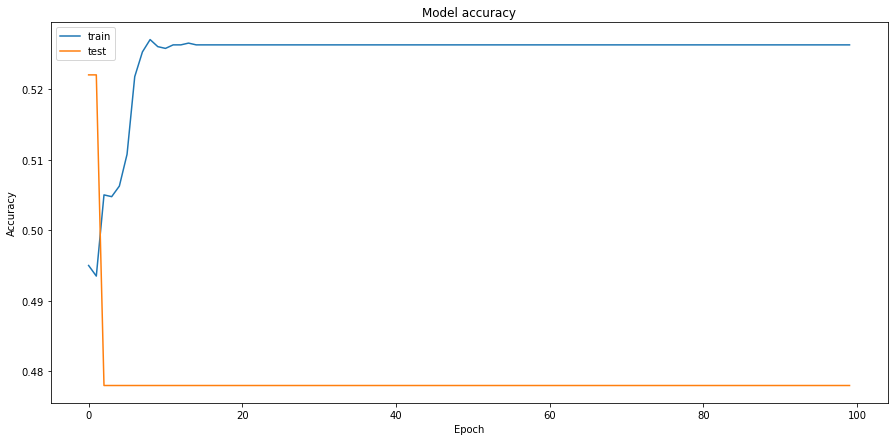

In [39]:
# Plot Accuracy.
plt.figure(figsize=(15, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

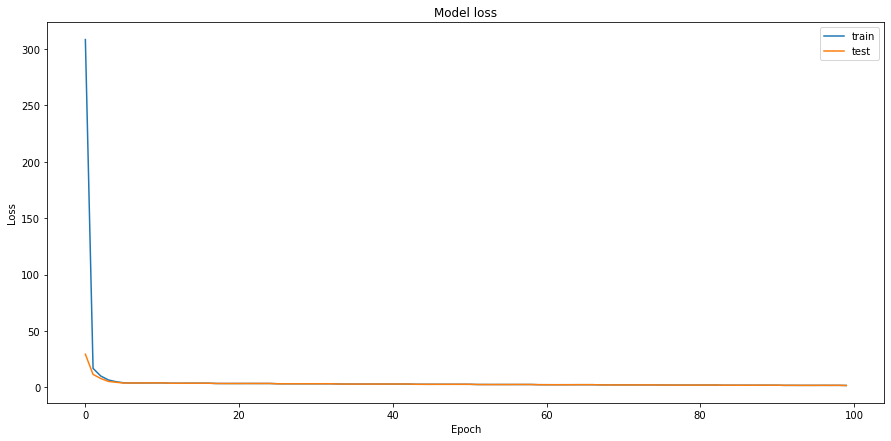

In [40]:
# Plot Loss.
plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# LSTM

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [42]:
df = pd.read_csv('WMT.csv', usecols=['Date', 'Close'])

In [43]:
df.set_index('Date', inplace=True)

In [44]:
walmart = df.values

In [45]:
transformedData = scaler.fit_transform(walmart)

In [46]:
timesteps = 60

In [47]:
x, y = [], []

for i in range(timesteps, len(walmart)):
    x.append(transformedData[i-timesteps:i, 0])
    y.append(transformedData[i, 0])

In [48]:
x = np.array(x)
y = np.array(y)

In [49]:
x_train = x[:4000]
y_train = y[:4000]

In [50]:
x_test = x[4000:]
y_test = y[4000:]

In [51]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [52]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [53]:
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=128, verbose=0)

In [54]:
predictions = (model.predict(x_test))

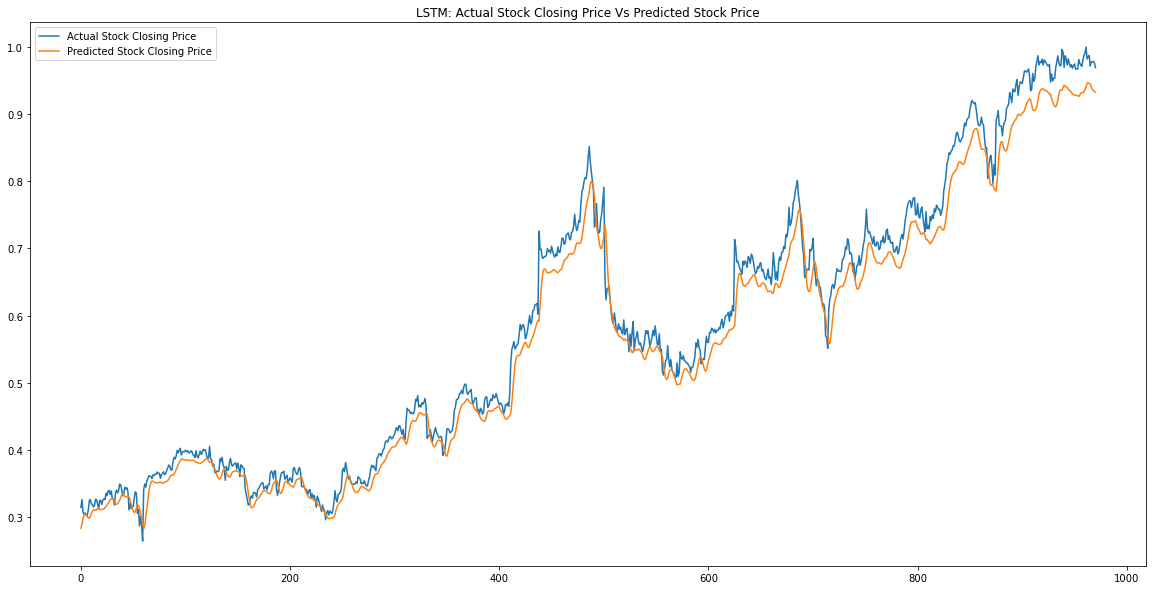

In [55]:
# Plotting the Actual Stock Closing Price vs Predicted Stock Closing Price.
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Actual Stock Closing Price')
plt.plot(predictions, label='Predicted Stock Closing Price')
plt.legend()
plt.title('LSTM: Actual Stock Closing Price Vs Predicted Stock Price')
plt.show()

In [56]:
end = time.time()
print('Runtime:', end - start)

Runtime: 249.79121351242065
